In [40]:
import pandas as pd
import pandasql as psql
import time
import math
import os
import role_classification_functions as rcf
import seaborn as sns
pd.options.display.max_columns = None

fname=os.getcwd()+'\\database'+'\\SouporSecret_4_2.csv'
df_soup=pd.read_csv(fname)
df_soup1=df_soup[df_soup['queue'].isin(['5v5 Draft Pick games','5v5 Ranked Flex games','5v5 Ranked Solo games','5v5 Blind Pick games','Clash games'])]
df_soup2=rcf.new_lane_classification(df_soup1,cleaning=True)
print(rcf.score_error(df_soup2))
df=df_soup2[df_soup2['role_error_flag'] == False].copy()
print(rcf.score_error(df))
print(len(df), "rows")
print(len(df['gameId'].drop_duplicates()), "games")
df.head(3)

8
0
25800 rows
82 games


,minute,participantId,totalGold,level,xp,minionsKilled,jungleMinionsKilled,gameId,queue,teamId,win,champion_name,role,lane,summonerName,pos_x,pos_y,spell0,spell1,item0,item1,item2,item3,item4,item5,pos_lane,jungle_flag,support_flag,final_role,role_error_flag
0,0,7,500,1,0,0,0,3849016581,5v5 Draft Pick games,Red,False,Darius,SOLO,TOP,Boss 0f This Gym,14180,14271,Flash,Teleport,Thornmail,Stridebreaker,Plated Steelcaps,Sterak's Gage,Dead Man's Plate,Caulfield's Warhammer,TOP,False,False,TOP,False
1,1,7,500,1,0,0,0,3849016581,5v5 Draft Pick games,Red,False,Darius,SOLO,TOP,Boss 0f This Gym,6767,11479,Flash,Teleport,Thornmail,Stridebreaker,Plated Steelcaps,Sterak's Gage,Dead Man's Plate,Caulfield's Warhammer,TOP,False,False,TOP,False
2,2,7,584,1,181,3,0,3849016581,5v5 Draft Pick games,Red,False,Darius,SOLO,TOP,Boss 0f This Gym,2170,12608,Flash,Teleport,Thornmail,Stridebreaker,Plated Steelcaps,Sterak's Gage,Dead Man's Plate,Caulfield's Warhammer,TOP,False,False,TOP,False


In [28]:
''' @Params
    df = name of dataframe
    name = summoner name to mark
    Returns dataframe with column homeTeam, which is True if the team contains the entered summoner name. name is not case sensitive
'''
def mark_summoner(df, name):
    name_lower = name.lower()
    df['summonerName']=df['summonerName'].str.lower()
    df_1 = df[['gameId','summonerName','teamId']].copy().drop_duplicates()
    df_2=df_1[df_1['summonerName']==name_lower].copy()
    df_2['homeTeam'] = [True for i in range(len(df_2))]
    #df_2.drop(['summonerName'],inplace=True)

    df_3=df.merge(df_2[['gameId','teamId','homeTeam']],how='left',on = ['gameId','teamId'])
    df_3.fillna(False,inplace=True)
    return df_3

In [29]:
''' @Params
    df = name of dataframe
    name = summoner name **NOT USED YET
    minutes = time  to see gold diff
    ROLE = position: BOT_CARRY, SUPPORT, MIDDLE, JUNGLE, TOP
'''
def gold_diff_x(df, name, minutes=[10], role="BOT_CARRY"):
    
    df_1=mark_summoner(df,name)
    #print(len(df_1))
 
    df_out = pd.DataFrame()
    for minute, i in zip(minutes,range(len(minutes))):
        df_2=df_1[df_1['minute']==minute]
        prep=df_2[['gameId','minute','homeTeam','summonerName','champion_name','totalGold','minionsKilled','jungleMinionsKilled','final_role']].copy()

        home=prep[(prep['summonerName']==name.lower()) & (prep['homeTeam']==True) & (prep['final_role']==role)].copy()
        away=prep[(prep['homeTeam']==False) & (prep['final_role']==role) ].copy()
        
        df_versus=home.merge(away, on = ["gameId","minute"])
        gd_col='goldDiff'+str(minute)
        csd_col='csDiff'+str(minute)
        df_versus[gd_col]=df_versus['totalGold_x'] - df_versus['totalGold_y'] 
        df_versus[csd_col]=df_versus['minionsKilled_x'] + df_versus['jungleMinionsKilled_x'] - df_versus['minionsKilled_y'] - df_versus['jungleMinionsKilled_y'] 
        df_stats=df_versus[['gameId', 'champion_name_x','champion_name_y', gd_col, csd_col]]

        #combine stats for each minute
        if i==0:
            df_out=df_out.append(df_stats)
        else:
            df_out=df_out.merge(df_stats, on=['gameId', 'champion_name_x','champion_name_y'],how="left")

    return df_out

    #Returns summary of output of gold_diff function
def summarize_stats(df,champ_team="home"):
    if champ_team == "home" or champ_team == "Home":
        champ_name_type='champion_name_x'
    else:
        champ_name_type='champion_name_y'

    stats_list=[]
    
    for champ in df[champ_name_type].drop_duplicates():
        champ_row = {}
        champ_df=df[df[champ_name_type]==champ]
        champ_row['champion']=champ
        champ_row['games']=len(champ_df)
        for column in list(champ_df.columns[3:]):
            champ_row[column]=champ_df[column].mean(skipna=True)
        stats_list.append(champ_row)

    return pd.DataFrame(stats_list).round(0).sort_values(by='games',ascending=False)


In [37]:
display(summarize_stats(gold_diff_x(df,"SouporSecret",minutes=[10, 15],role="SUPPORT")))
display(summarize_stats(gold_diff_x(df,"SouporSecret",minutes=[10, 15],role="SUPPORT"),champ_team="Away"))


,champion,games,goldDiff10,csDiff10,goldDiff15,csDiff15
5,Seraphine,27,299.0,-5.0,660.0,-5.0
0,Thresh,9,-146.0,5.0,19.0,6.0
2,Zyra,7,519.0,-8.0,819.0,-12.0
3,Leona,7,-39.0,6.0,36.0,8.0
1,Alistar,3,-74.0,3.0,-210.0,7.0
6,Karma,2,-565.0,-8.0,-685.0,-8.0
8,Bard,2,646.0,-4.0,879.0,-4.0
4,Blitzcrank,1,-61.0,10.0,-900.0,18.0
7,Morgana,1,-142.0,5.0,180.0,10.0
9,Nautilus,1,18.0,10.0,-340.0,14.0


,champion,games,goldDiff10,csDiff10,goldDiff15,csDiff15
3,Senna,6,118.0,2.0,276.0,5.0
15,Nautilus,6,158.0,-4.0,380.0,-5.0
14,Lux,5,-52.0,4.0,136.0,9.0
4,Rell,4,781.0,-4.0,1336.0,-8.0
17,Thresh,4,87.0,-10.0,680.0,-14.0
8,Bard,4,-324.0,-2.0,-259.0,2.0
11,Yuumi,3,437.0,6.0,1139.0,10.0
22,Seraphine,3,-107.0,1.0,-259.0,2.0
1,Blitzcrank,3,18.0,-10.0,252.0,-9.0
19,Alistar,2,664.0,-6.0,716.0,-5.0


In [39]:
display(summarize_stats(gold_diff_x(df,"AerialBlast",minutes=[10, 15],role="BOT_CARRY")))
display(summarize_stats(gold_diff_x(df,"AerialBlast",minutes=[10, 15],role="BOT_CARRY"),champ_team="Away"))


,champion,games,goldDiff10,csDiff10,goldDiff15,csDiff15
3,Kaisa,15,419.0,4.0,783.0,8.0
4,Tristana,14,368.0,-1.0,765.0,0.0
1,Sivir,5,-345.0,12.0,-386.0,17.0
0,Draven,3,-478.0,-5.0,-138.0,-17.0
7,Caitlyn,3,230.0,14.0,719.0,19.0
8,Senna,3,441.0,16.0,486.0,14.0
2,MissFortune,1,869.0,32.0,2375.0,34.0
5,Jhin,1,-488.0,9.0,-515.0,1.0
6,Jinx,1,761.0,-5.0,784.0,-6.0


,champion,games,goldDiff10,csDiff10,goldDiff15,csDiff15
1,Kaisa,8,451.0,5.0,813.0,8.0
2,Ezreal,8,429.0,4.0,680.0,4.0
0,Tristana,5,101.0,12.0,865.0,18.0
12,Samira,5,108.0,2.0,235.0,-5.0
5,Senna,3,162.0,12.0,-167.0,23.0
7,Jhin,3,-101.0,-6.0,477.0,-15.0
8,Jinx,3,202.0,7.0,325.0,8.0
4,Ashe,2,482.0,12.0,1314.0,18.0
11,Caitlyn,2,-22.0,-14.0,423.0,-10.0
3,Draven,1,-933.0,-7.0,-2738.0,-23.0


30  games, 
-33 avg gold diff


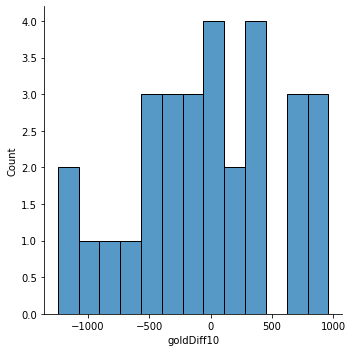

In [18]:
kev_adc=gold_diff_x(df,"AerialBlast",minutes=[10,15],role="BOT_CARRY")
sns.displot(kev_adc.goldDiff10, bins =13)
print(len(kev_adc), " games, ")
print(int(kev_adc.goldDiff10.mean()), "avg gold diff")

30  games, 
38 avg gold diff


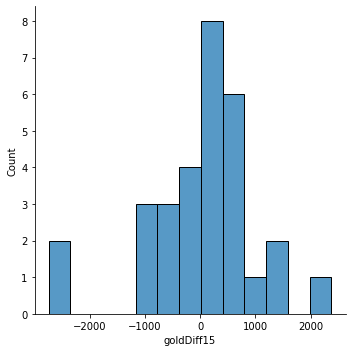

In [19]:
sns.displot(kev_adc.goldDiff15, bins = 13)
print(len(kev_adc), " games, ")
print(int(kev_adc.goldDiff15.mean()), "avg gold diff")

61  games, 
147 avg gold diff


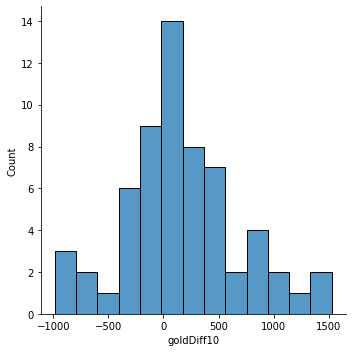

In [10]:
mike_support=gold_diff_x(df,"SouporSecret",minutes=[10,15],role="SUPPORT")
sns.displot(mike_support.goldDiff10, bins = 13)
print(len(mike_support), " games, ")
print(int(mike_support.goldDiff10.mean()), "avg gold diff")

61  games, 
346 avg gold diff


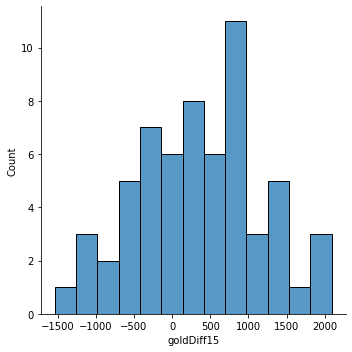

In [11]:
sns.displot(mike_support.goldDiff15, bins = 13)
print(len(mike_support), " games, ")
print(int(mike_support.goldDiff15.mean()), "avg gold diff")